In [3473]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
from pathlib import Path
#Plotting

from waterfall_ax import WaterfallChart
import matplotlib.pyplot as plt


In [3474]:
#Define the working directory
dir_path = "./"
#File names for import
all_data_file = Path(dir_path, "all_data.csv")
revenue_file = Path(dir_path, "revenue_only.csv")
forecast_file = Path(dir_path, "forecast_country.csv")

In [3475]:
#Read in all the data
all_data = pd.read_csv(all_data_file)
revenue_data = pd.read_csv(revenue_file)
forecast_data = pd.read_csv(forecast_file)
forecast_data["Country"] = forecast_data["Country"].replace({"Rest":'Rest-EU'})
forecast_data = forecast_data.rename(columns={"Volume":"Forecast"})

In [3476]:
#Dict for correcting the country names
country_dict = {'CANADA': 'Canada',
 'SPAIN': 'Spain',
 'ITALY': 'Italy',
 'URUGUAY': 'Latam',
 'BRAZIL': 'Latam',
 'ARGENTINA': 'Latam',
 'HUNGARY': 'Rest-EU',
 'UNITED KINGDOM': 'UK',
 'MEXICO': 'Latam',
 'BELGIUM': 'Rest-EU',
 'TURKEY': 'Turkey',
 'COLOMBIA': 'Latam',
 'PERU': 'Latam',
 'FRANCE': 'France',
 'GERMANY': 'Rest-EU',
 'PORTUGAL': 'Rest-EU',
 'SWITZERLAND': 'Rest-EU',
 'COSTA RICA': 'Latam',
 'CHILE': 'Latam',
 'SWEDEN': 'Rest-EU',
 'NETHERLANDS': 'Rest-EU',
 'DENMARK': 'Rest-EU',
 'IRELAND': 'Rest-EU',
 'GREECE': 'Rest-EU',
 'AUSTRIA': 'Rest-EU',
 'CZECH REPUBLIC': 'Rest-EU',
 'CROATIA': 'Rest-EU',
 'UKRAINE': 'Rest-EU',
 'SLOVENIA': 'Rest-EU',
 'RUSSIA': 'Rest-EU',
 'BELARUS': 'Rest-EU',
 'FINLAND': 'Rest-EU',
 'PUERTO RICO': 'Latam',
 'LITHUANIA': 'Rest-EU',
 'NORTH MACEDONIA': 'Rest-EU',
 'ROMANIA': 'Rest-EU',
 'LUXEMBOURG': 'Rest-EU',
 'POLAND': 'Rest-EU'}

 

In [3477]:
#Define function that transforms to same data format
def forecast_periode(data):
    data = " ".join([data[4:], data[0:4]])
    return data

#all_data = all_data["Quarter_Year"].map(forecast_periode)
all_data["Forecast_Region"] = all_data["Reporting Country"].map(country_dict)
#Cast the time period to be in the correct data format
all_data["Quarter_Year"] = all_data["Quarter_Year"].map(forecast_periode)

In [3478]:
all_data["Date Received"] = pd.to_datetime(all_data["Date Received"])
all_data = all_data.set_index("Date Received")
all_data = all_data.drop(columns=["Product"], axis = 1)
all_data = all_data.rename(columns={"Reporting Country  ↑":"Country", "new LIMS Project ID":"Product", "Quarter_Year":"Time", 'Sales':"Actuals"})
all_data = all_data[["Forecast_Region","Time", "Product", "Type" , "Actuals"]]


In [3479]:
print(f"The most recent date in the dataset is {all_data.index.max()}")

The most recent date in the dataset is 2023-10-09 00:00:00


In [3480]:
# Selector

#Select the commercial sampels
all_commercial = all_data[all_data["Type"] == "Commercial"]
quarter = "Q4 2023"
persona = "Country"
temp = 3
Month_into_quarter = 1

Q4_2023_forecast = forecast_data.loc[(forecast_data["Time"] == quarter) & (forecast_data["Forecaster"] == persona)]

In [3481]:
#Group the sales data by country, quarter and product
commercial_grouped = all_commercial.groupby(["Forecast_Region","Time", "Product"])["Actuals"].sum().reset_index()
commercial_grouped = commercial_grouped.rename(columns={"Forecast_Region":"Country"})


In [3482]:
commercial_grouped

,Country,Time,Product,Actuals
0,Canada,Q1 2020,G360 CDx,5
1,Canada,Q1 2021,G360 CDx,2
2,Canada,Q1 2022,G360 CDx,7
3,Canada,Q1 2023,G360 CDx,21
4,Canada,Q1 2023,G360 Infinity,4
...,...,...,...,...
163,UK,Q4 2022,G360 CDx,241
164,UK,Q4 2022,G360 Infinity,5
165,UK,Q4 2022,Reveal,1
166,UK,Q4 2023,G360 CDx,18


In [3483]:
results = pd.merge(Q4_2023_forecast, commercial_grouped, how = "left", on=["Country", "Time", "Product"])

results.sample(5)

,Forecaster,Country,Time,Product,5QRF_Starting_Quarter,ASP,Forecast,Actuals
22,Country,Italy,Q4 2023,Reveal,Q4_23,0,0,NaN
19,Country,Latam,Q4 2023,Shield,Q4_23,0,0,NaN
29,Country,France,Q4 2023,G360 Infinity,Q4_23,0,0,NaN
3,Country,Canada,Q4 2023,Shield,Q4_23,0,0,NaN
17,Country,Latam,Q4 2023,G360 Infinity,Q4_23,2900,5,NaN


In [3484]:
results = results.fillna(0,axis = 1)
results.sample(2)

,Forecaster,Country,Time,Product,5QRF_Starting_Quarter,ASP,Forecast,Actuals
23,Country,Italy,Q4 2023,Shield,Q4_23,0,0,0
7,Country,Spain,Q4 2023,Shield,Q4_23,0,0,0


In [3485]:
results = pd.merge(Q4_2023_forecast, commercial_grouped, how = "left", on=["Country", "Time", "Product"])
results = results.fillna(0,axis = 1)
results["Actuals"] = results["Actuals"].astype(int)
results["Temp_Forecast"] = (results["Forecast"]/temp).astype(float).round(0)
results["Forecast_gap"] = results["Actuals"] - results["Temp_Forecast"]




In [3486]:
results_by_country = results[results["Country"]== "UK"].reset_index(drop = True)
results_by_country["Waterfall"] = results_by_country["Forecast_gap"]
results_by_country.loc[0,"Waterfall"] = results_by_country.loc[0, "Temp_Forecast"] - results_by_country.loc[0, "Actuals"]

In [3487]:
results_by_country.head(5)

,Forecaster,Country,Time,Product,5QRF_Starting_Quarter,ASP,Forecast,Actuals,Temp_Forecast,Forecast_gap,Waterfall
0,Country,UK,Q4 2023,G360 CDx,Q4_23,1545,132,18,44.0,-26.0,26.0
1,Country,UK,Q4 2023,G360 Infinity,Q4_23,3000,5,3,2.0,1.0,1.0
2,Country,UK,Q4 2023,Reveal,Q4_23,3000,5,0,2.0,-2.0,-2.0
3,Country,UK,Q4 2023,Shield,Q4_23,0,0,0,0.0,0.0,0.0


In [3488]:
results_by_country.loc[0,"Waterfall"] = results_by_country.loc[0, "Temp_Forecast"] - results_by_country.loc[0, "Actuals"]

In [3489]:
results_by_country

,Forecaster,Country,Time,Product,5QRF_Starting_Quarter,ASP,Forecast,Actuals,Temp_Forecast,Forecast_gap,Waterfall
0,Country,UK,Q4 2023,G360 CDx,Q4_23,1545,132,18,44.0,-26.0,26.0
1,Country,UK,Q4 2023,G360 Infinity,Q4_23,3000,5,3,2.0,1.0,1.0
2,Country,UK,Q4 2023,Reveal,Q4_23,3000,5,0,2.0,-2.0,-2.0
3,Country,UK,Q4 2023,Shield,Q4_23,0,0,0,0.0,0.0,0.0


In [3490]:
columns = ["Forecast", "G360 CDx", "G360 Infinity","Reveal","Shield", "Forecast"]

def plot_country_waterfall(country):
    results_by_country = results[results["Country"]== country].reset_index(drop = True)
    results_by_country["Waterfall"] = results_by_country["Forecast_gap"]
    results_by_country.loc[0,"Waterfall"] = results_by_country.loc[0, "Temp_Forecast"] - results_by_country.loc[0, "Actuals"]
    results_by_country["Waterfall_cumsum"] = results_by_country["Waterfall"].cumsum()
    result_list = results_by_country["Waterfall_cumsum"].to_list()
    result_list.insert(0,results_by_country._get_value(0,"Temp_Forecast"))
    plt.style.use('dark_background')

    step_names = ["Forecast", "G360 CDx", "G360 Infinity","Reveal","Shield"]
# Plot
    waterfall = WaterfallChart(result_list, step_names=step_names)
    color_kwargs = {
    'c_bar_pos': 'lightgreen',
    'c_bar_neg': 'orange',
    'c_bar_start': 'white',
    'c_bar_end': 'white',
    'c_text_pos': 'white',    
    'c_text_neg': 'white',
    'c_text_start': 'yellow',
    'c_text_end': 'yellow'
}
    wf_ax = waterfall.plot_waterfall(title=f'Gap Analysis for the { results_by_country.loc[0, "Country"] } ' , color_kwargs=color_kwargs)
    plt.savefig(f"{country}.pdf")

/Users/mhausch/Data/GH_Dashboards/envs/lib/python3.9/site-packages/waterfall_ax/waterfall_ax.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = '{:,}'.format(int(df_plot[self.delta_col][i]))
/Users/mhausch/Data/GH_Dashboards/envs/lib/python3.9/site-packages/waterfall_ax/waterfall_ax.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = '{:,}'.format(int(df_plot[self.delta_col][i]))
/Users/mhausch/Data/GH_Dashboards/envs/lib/python3.9/site-packages/waterfall_ax/waterfall_ax.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

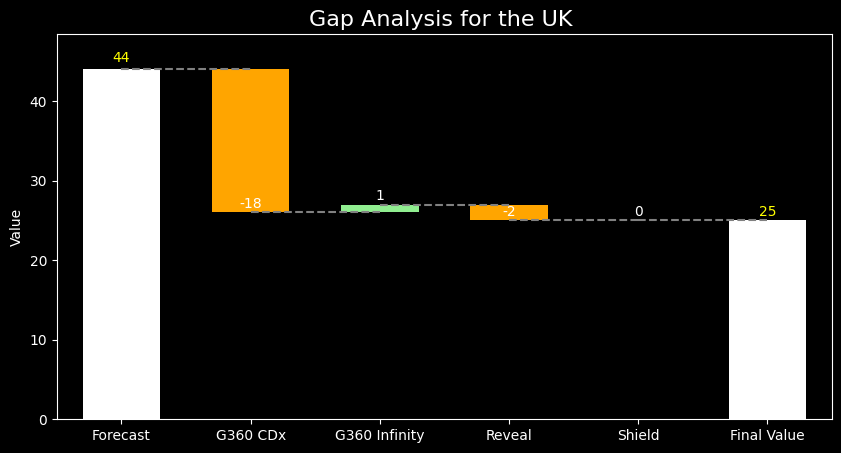

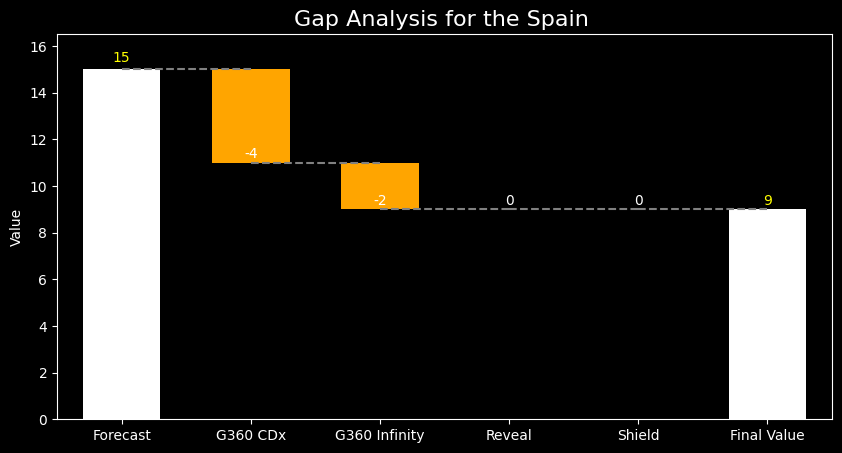

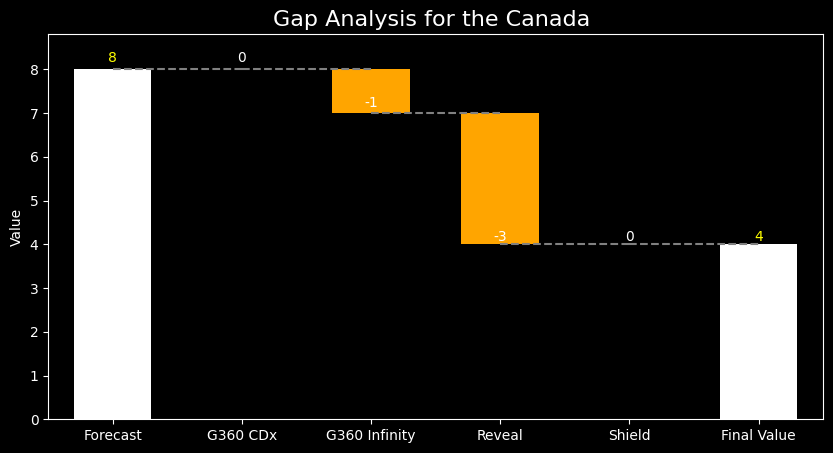

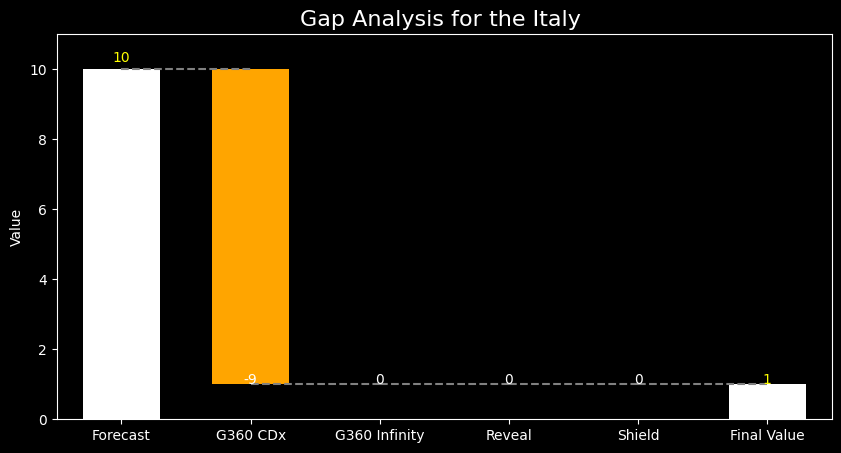

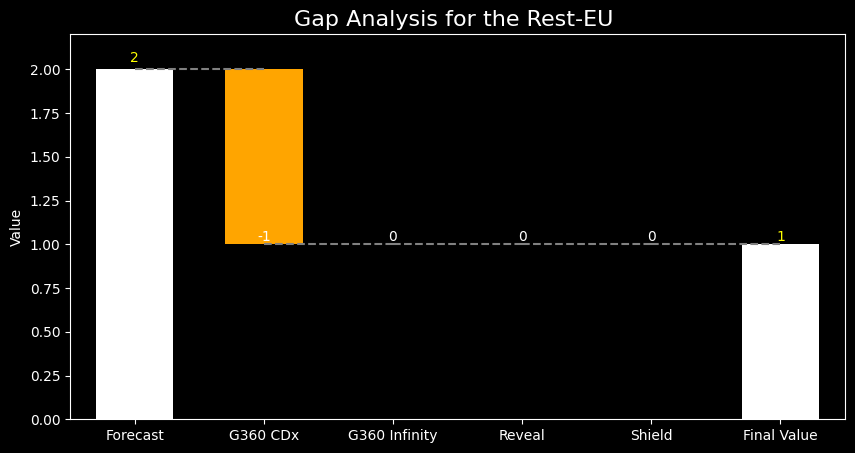

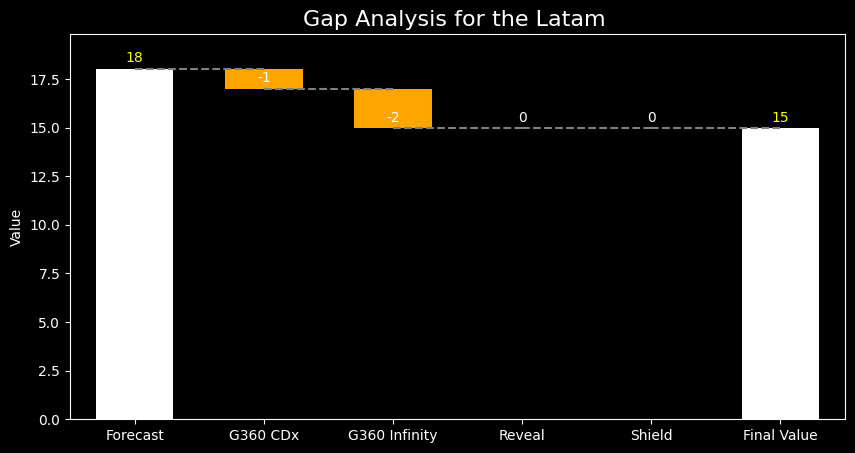

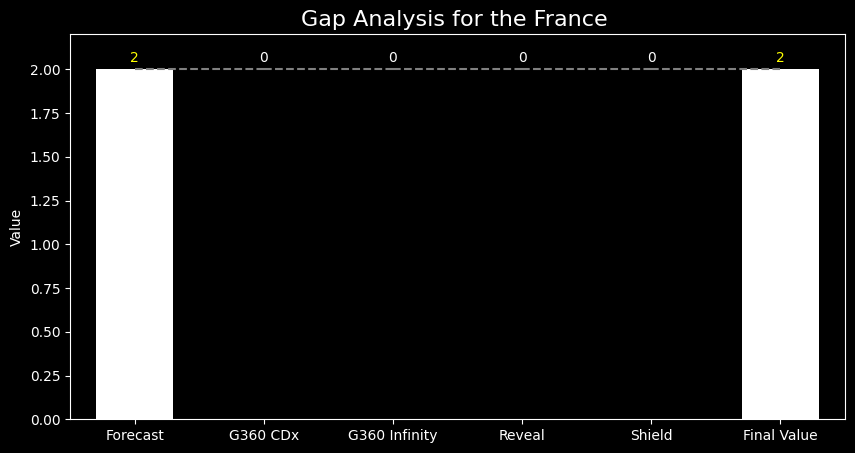

In [3491]:
countries = ["UK", "Spain", "Canada", "Italy", "Rest-EU", "Latam", "France"]

for country in countries:
    plot_country_waterfall(country)
    

# Plot the gap analysis for EUAA vs countries

In [3492]:
#Define the input dataframe

EUAA_forecast = forecast_data.copy()
EUAA_sales = all_data.copy()

In [3493]:
# Selector

#Select the commercial sampels
EUAA_sales_commercial = EUAA_sales[EUAA_sales["Type"] == "Commercial"]
quarter = "Q4 2023"
persona = "Country"
temp = 3
Month_into_quarter = 1

In [3494]:
 EUAA_sales_commercial = EUAA_sales_commercial[EUAA_sales_commercial["Time"] == "Q4 2023"]
 EUAA_sales_commercial = EUAA_sales_commercial.groupby(["Forecast_Region"])["Actuals"].sum().reset_index()
 EUAA_sales_commercial = EUAA_sales_commercial.rename(columns={"Forecast_Region":"Country"})


In [3495]:

EUAA_forecast_filtered = EUAA_forecast.loc[(EUAA_forecast["Time"] == quarter) & (EUAA_forecast["Forecaster"] == persona)]
EUAA_forecast_filtered = EUAA_forecast_filtered.groupby(["Country"])["Forecast"].sum().reset_index()

In [3496]:
#Create the results dataframe
EUAA_results = pd.merge(EUAA_forecast_filtered, EUAA_sales_commercial, how = "left", on=["Country"])
EUAA_results = EUAA_results.fillna(0,axis = 1)
EUAA_results["Actuals"] = EUAA_results["Actuals"].astype(int)
EUAA_results["Temp_Forecast"] = (EUAA_results["Forecast"]/temp).astype(float).round(0)
EUAA_results["Forecast_gap"] = EUAA_results["Actuals"] - EUAA_results["Temp_Forecast"]

In [3497]:
EUAA_results.head(5)

,Country,Forecast,Actuals,Temp_Forecast,Forecast_gap
0,Canada,42,1,14.0,-13.0
1,France,5,0,2.0,-2.0
2,Italy,30,9,10.0,-1.0
3,Latam,59,1,20.0,-19.0
4,Rest-EU,5,1,2.0,-1.0


In [3498]:
EUAA_results["Waterfall"] = EUAA_results["Forecast_gap"]

In [3499]:
#EUAA_results.loc[0,"Waterfall"] = EUAA_results.loc[0, "Temp_Forecast"] - EUAA_results.loc[0, "Actuals"]

In [3500]:
 EUAA_results = EUAA_results.set_index("Country")


In [3501]:
 EUAA_results.loc["Total"] = EUAA_results.sum( axis=0)

In [3502]:
EUAA_results = EUAA_results.reset_index()
EUAA_results


,Country,Forecast,Actuals,Temp_Forecast,Forecast_gap,Waterfall
0,Canada,42,1,14.0,-13.0,-13.0
1,France,5,0,2.0,-2.0,-2.0
2,Italy,30,9,10.0,-1.0,-1.0
3,Latam,59,1,20.0,-19.0,-19.0
4,Rest-EU,5,1,2.0,-1.0,-1.0
5,Spain,50,4,17.0,-13.0,-13.0
6,Turkey,70,8,23.0,-15.0,-15.0
7,UK,142,21,47.0,-26.0,-26.0
8,Total,403,45,135.0,-90.0,-90.0


In [3503]:
EUAA_results = EUAA_results.loc[::-1].sort_values("Waterfall")
EUAA_results

,Country,Forecast,Actuals,Temp_Forecast,Forecast_gap,Waterfall
8,Total,403,45,135.0,-90.0,-90.0
7,UK,142,21,47.0,-26.0,-26.0
3,Latam,59,1,20.0,-19.0,-19.0
6,Turkey,70,8,23.0,-15.0,-15.0
5,Spain,50,4,17.0,-13.0,-13.0
0,Canada,42,1,14.0,-13.0,-13.0
1,France,5,0,2.0,-2.0,-2.0
4,Rest-EU,5,1,2.0,-1.0,-1.0
2,Italy,30,9,10.0,-1.0,-1.0


In [3504]:

EUAA_results.loc[(EUAA_results["Country"] == "Total"),"Waterfall"] = EUAA_results.loc[(EUAA_results["Country"] == "Total"),"Temp_Forecast"]


In [3505]:

EUAA_results

,Country,Forecast,Actuals,Temp_Forecast,Forecast_gap,Waterfall
8,Total,403,45,135.0,-90.0,135.0
7,UK,142,21,47.0,-26.0,-26.0
3,Latam,59,1,20.0,-19.0,-19.0
6,Turkey,70,8,23.0,-15.0,-15.0
5,Spain,50,4,17.0,-13.0,-13.0
0,Canada,42,1,14.0,-13.0,-13.0
1,France,5,0,2.0,-2.0,-2.0
4,Rest-EU,5,1,2.0,-1.0,-1.0
2,Italy,30,9,10.0,-1.0,-1.0


In [3506]:
EUAA_results["Waterfall_cumsum"] = EUAA_results["Waterfall"].cumsum()



In [3507]:
EUAA_results.head(3)

,Country,Forecast,Actuals,Temp_Forecast,Forecast_gap,Waterfall,Waterfall_cumsum
8,Total,403,45,135.0,-90.0,135.0,135.0
7,UK,142,21,47.0,-26.0,-26.0,109.0
3,Latam,59,1,20.0,-19.0,-19.0,90.0


In [3508]:
EUAA_waterfall_input = EUAA_results["Waterfall_cumsum"].astype("int").to_list()


In [3509]:
step_names_EUAA = EUAA_results["Country"].to_list()


In [3529]:
step_names_EUAA

['Total',
 'UK',
 'Latam',
 'Turkey',
 'Spain',
 'Canada',
 'France',
 'Rest-EU',
 'Italy']

/Users/mhausch/Data/GH_Dashboards/envs/lib/python3.9/site-packages/waterfall_ax/waterfall_ax.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = '{:,}'.format(int(df_plot[self.delta_col][i]))


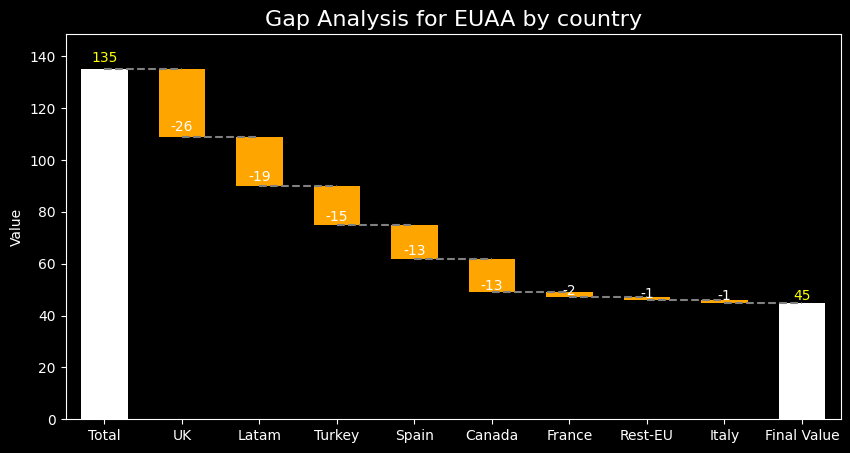

In [3510]:
waterfall_EUAA = WaterfallChart(EUAA_waterfall_input,step_names= step_names_EUAA )
color_kwargs = {
'c_bar_pos': 'lightgreen',
'c_bar_neg': 'orange',
'c_bar_start': 'white',
'c_bar_end': 'white',
'c_text_pos': 'white',    
    'c_text_neg': 'white',
    'c_text_start': 'yellow',
    'c_text_end': 'yellow'}
wf_ax = waterfall_EUAA.plot_waterfall(title=f'Gap Analysis for EUAA by country' , color_kwargs=color_kwargs)
plt.savefig(f"EUAA_gap_analysis.pdf")

### EUAA gap analysis by Product

In [3511]:
EUAA_forecast = forecast_data.copy()
EUAA_sales = all_data.copy()

In [3512]:
EUAA_forecast.head(3)

,Forecaster,Country,Time,Product,5QRF_Starting_Quarter,ASP,Forecast
0,Country,Canada,Q1 2024,G360 CDx,Q4_23,1450,30
1,Country,Canada,Q1 2024,G360 Infinity,Q4_23,1700,9
2,Country,Canada,Q1 2024,Reveal,Q4_23,1700,10


In [3513]:
EUAA_sales.head(3)

,Forecast_Region,Time,Product,Type,Actuals
Date Received,,,,,
2020-04-28,Latam,Q2 2020,NaN,Biopharma,1
2020-06-05,Latam,Q2 2020,NaN,Biopharma,1
2021-06-04,Latam,Q2 2021,NaN,Biopharma,1


In [3514]:
#Select the commercial sampels
EUAA_sales_commercial = EUAA_sales[EUAA_sales["Type"] == "Commercial"]
quarter = "Q4 2023"
persona = "Country"
temp = 3
Month_into_quarter = 1

In [3515]:
#Create the sales dataframe for the gap analysis
EUAA_gap_product_input = EUAA_sales[EUAA_sales["Time"] == "Q4 2023"]
EUAA_gap_product_input = EUAA_gap_product_input.groupby(["Product"])["Actuals"].sum().reset_index()
EUAA_gap_product_input = EUAA_gap_product_input.rename(columns={"Forecast_Region":"Country"})
EUAA_gap_product_input

,Product,Actuals
0,G360 CDx,34
1,G360 Infinity,11
2,Reveal,2


In [3516]:
#Create the forecast dataframe for the gap analysis
EUAA_gap_product_forecast = EUAA_forecast.loc[(EUAA_forecast["Time"] == quarter) & (EUAA_forecast["Forecaster"] == persona)]
EUAA_gap_product_forecast = EUAA_gap_product_forecast.groupby(["Product"])["Forecast"].sum().reset_index()
EUAA_gap_product_forecast

,Product,Forecast
0,G360 CDx,316
1,G360 Infinity,57
2,Reveal,30
3,Shield,0


In [3517]:
EUAA_gap_product_forecast = pd.merge(EUAA_gap_product_input, EUAA_gap_product_forecast, how = "left", on=["Product"])
EUAA_gap_product_forecast

,Product,Actuals,Forecast
0,G360 CDx,34,316
1,G360 Infinity,11,57
2,Reveal,2,30


In [3518]:
EUAA_gap_product_forecast = EUAA_gap_product_forecast.fillna(0,axis = 1)
EUAA_gap_product_forecast["Actuals"] = EUAA_gap_product_forecast["Actuals"].astype(int)
EUAA_gap_product_forecast["Temp_Forecast"] = (EUAA_gap_product_forecast["Forecast"]/temp).astype(float).round(0)
EUAA_gap_product_forecast["Forecast_gap"] = EUAA_gap_product_forecast["Actuals"] - EUAA_gap_product_forecast["Temp_Forecast"]

In [3519]:
EUAA_gap_product_forecast

,Product,Actuals,Forecast,Temp_Forecast,Forecast_gap
0,G360 CDx,34,316,105.0,-71.0
1,G360 Infinity,11,57,19.0,-8.0
2,Reveal,2,30,10.0,-8.0


In [3520]:
EUAA_gap_product_forecast["Waterfall"] = EUAA_gap_product_forecast["Forecast_gap"]
EUAA_gap_product_forecast = EUAA_gap_product_forecast.set_index("Product")
EUAA_gap_product_forecast.loc["Total"] = EUAA_gap_product_forecast.sum( axis=0)
EUAA_gap_product_forecast = EUAA_gap_product_forecast.reset_index()




In [3521]:
EUAA_gap_product_forecast

,Product,Actuals,Forecast,Temp_Forecast,Forecast_gap,Waterfall
0,G360 CDx,34,316,105.0,-71.0,-71.0
1,G360 Infinity,11,57,19.0,-8.0,-8.0
2,Reveal,2,30,10.0,-8.0,-8.0
3,Total,47,403,134.0,-87.0,-87.0


In [3522]:
EUAA_gap_product_forecast = EUAA_gap_product_forecast.loc[::-1].sort_values("Waterfall")
EUAA_gap_product_forecast

/Users/mhausch/Data/GH_Dashboards/envs/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,Product,Actuals,Forecast,Temp_Forecast,Forecast_gap,Waterfall
3,Total,47,403,134.0,-87.0,-87.0
0,G360 CDx,34,316,105.0,-71.0,-71.0
2,Reveal,2,30,10.0,-8.0,-8.0
1,G360 Infinity,11,57,19.0,-8.0,-8.0


In [3523]:
EUAA_gap_product_forecast.loc[(EUAA_gap_product_forecast["Product"] == "Total"),"Waterfall"] = EUAA_gap_product_forecast.loc[(EUAA_gap_product_forecast["Product"] == "Total"),"Temp_Forecast"]
EUAA_gap_product_forecast

,Product,Actuals,Forecast,Temp_Forecast,Forecast_gap,Waterfall
3,Total,47,403,134.0,-87.0,134.0
0,G360 CDx,34,316,105.0,-71.0,-71.0
2,Reveal,2,30,10.0,-8.0,-8.0
1,G360 Infinity,11,57,19.0,-8.0,-8.0


In [3524]:
#EUAA_gap_product_forecast.loc[(EUAA_gap_product_forecast["Product"] == "Total"),"Waterfall"] = EUAA_gap_product_forecast.loc[(EUAA_gap_product_forecast["Product"] == "Total"),"Temp_Forecast"]
EUAA_gap_product_forecast["Waterfall_cumsum"] = EUAA_gap_product_forecast["Waterfall"].cumsum()



In [3525]:
EUAA_gap_product_forecast

,Product,Actuals,Forecast,Temp_Forecast,Forecast_gap,Waterfall,Waterfall_cumsum
3,Total,47,403,134.0,-87.0,134.0,134.0
0,G360 CDx,34,316,105.0,-71.0,-71.0,63.0
2,Reveal,2,30,10.0,-8.0,-8.0,55.0
1,G360 Infinity,11,57,19.0,-8.0,-8.0,47.0


In [3526]:
EUAA_by_product_waterfall_input = EUAA_gap_product_forecast["Waterfall_cumsum"].astype("int").to_list()


In [3528]:
step_names_EUAA_by_product = EUAA_gap_product_forecast["Product"].to_list()
step_names_EUAA_by_product

['Total', 'G360 CDx', 'Reveal', 'G360 Infinity']

/Users/mhausch/Data/GH_Dashboards/envs/lib/python3.9/site-packages/waterfall_ax/waterfall_ax.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = '{:,}'.format(int(df_plot[self.delta_col][i]))


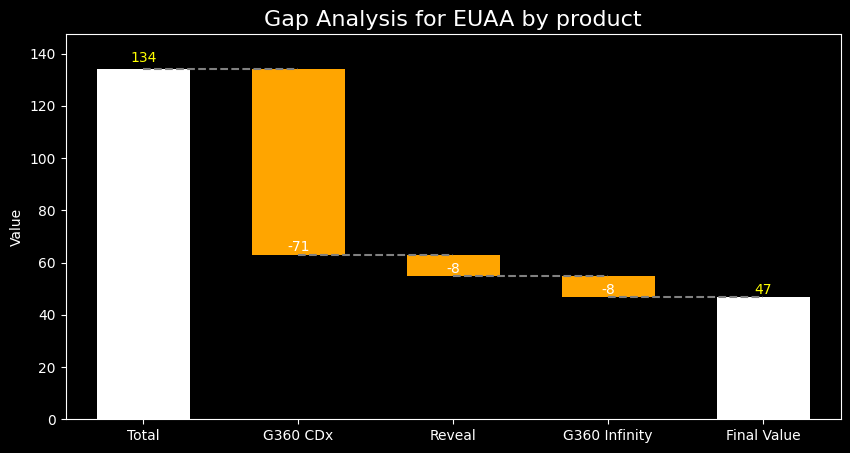

In [3531]:
waterfall_EUAA = WaterfallChart(EUAA_by_product_waterfall_input,step_names= step_names_EUAA_by_product )
color_kwargs = {
'c_bar_pos': 'lightgreen',
'c_bar_neg': 'orange',
'c_bar_start': 'white',
'c_bar_end': 'white',
'c_text_pos': 'white',    
    'c_text_neg': 'white',
    'c_text_start': 'yellow',
    'c_text_end': 'yellow'}
wf_ax = waterfall_EUAA.plot_waterfall(title=f'Gap Analysis for EUAA by product' , color_kwargs=color_kwargs)
plt.savefig(f"EUAA_gap_analysis_by_product.pdf")